In [1]:
import pandas as pd
from timeit import default_timer as timer
from scripts.models import VotingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score 
import numpy as np
import matplotlib.pyplot as plt
from seaborn import regplot

In [2]:
data, labels = pd.read_csv('../data/data_proc.csv'), pd.read_csv('../data/labels.csv')

In [3]:
import warnings

splitter = LeaveOneOut()
true_labels = []
pred_labels = []
train_time, eval_time = 0.0, 0.0
preds = np.zeros((133, 121))
model_folds = np.zeros(133).tolist()

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for fold, (train_ind, val_ind) in enumerate(splitter.split(data)):
        model = VotingClassifier(20, SVC(kernel='linear'))
        train_timer = timer()
        model.train(data.iloc[train_ind], labels.iloc[train_ind])
        train_time += timer() - train_timer
        eval_timer = timer()
        pred = model.predict(data.iloc[val_ind]).reshape(-1,)
        eval_time += timer() - eval_timer
        true_labels.append(labels.iloc[val_ind].values[0])
        pred_labels.append(pred[0])
        
        for model_num, submodel in enumerate(model.models):
            bin_pred = submodel.predict(data.iloc[val_ind]).reshape(-1,)
            # preds[fold][model_num] = submodel.predict(data.iloc[val_ind]).reshape(-1,)
            for i in range(int(model_num + 20*bin_pred), int(model_num + 20*bin_pred + 20)):
                preds[fold][i] += 1
        preds[fold] /= np.sum(preds[fold])
        print(f'[Fold {fold+1}/{splitter.get_n_splits(data)}] ==> True label: {true_labels[-1]}, Prediction: {pred_labels[-1]}')
        model_folds[fold] = model


print(f'Average train time: {(train_time / splitter.get_n_splits(data)):.6f} s, average eval time: {(eval_time / splitter.get_n_splits(data)):.6f} s')

[Fold 1/133] ==> True label: [19], Prediction: 20
[Fold 2/133] ==> True label: [19], Prediction: 29
[Fold 3/133] ==> True label: [19], Prediction: 19
[Fold 4/133] ==> True label: [19], Prediction: 19
[Fold 5/133] ==> True label: [20], Prediction: 19
[Fold 6/133] ==> True label: [20], Prediction: 66
[Fold 7/133] ==> True label: [31], Prediction: 17
[Fold 8/133] ==> True label: [31], Prediction: 31
[Fold 9/133] ==> True label: [32], Prediction: 26
[Fold 10/133] ==> True label: [32], Prediction: 32
[Fold 11/133] ==> True label: [33], Prediction: 12
[Fold 12/133] ==> True label: [33], Prediction: 23
[Fold 13/133] ==> True label: [37], Prediction: 23
[Fold 14/133] ==> True label: [37], Prediction: 40
[Fold 15/133] ==> True label: [37], Prediction: 69
[Fold 16/133] ==> True label: [39], Prediction: 20
[Fold 17/133] ==> True label: [51], Prediction: 61
[Fold 18/133] ==> True label: [52], Prediction: 31
[Fold 19/133] ==> True label: [55], Prediction: 26
[Fold 20/133] ==> True label: [57], Pred

In [4]:
mean_error = mean_absolute_error(np.array(true_labels), np.array(pred_labels))
median_error = median_absolute_error(np.array(true_labels), np.array(pred_labels))
r2 = r2_score(np.array(true_labels), np.array(pred_labels))

print(f'Mean absolute error: {mean_error}')
print(f'Median absolute error: {median_error}')
print(f'R2 score: {r2}')

Mean absolute error: 8.834586466165414
Median absolute error: 4.0
R2 score: 0.7483292426602596


Text(0, 0.5, 'Predictions')

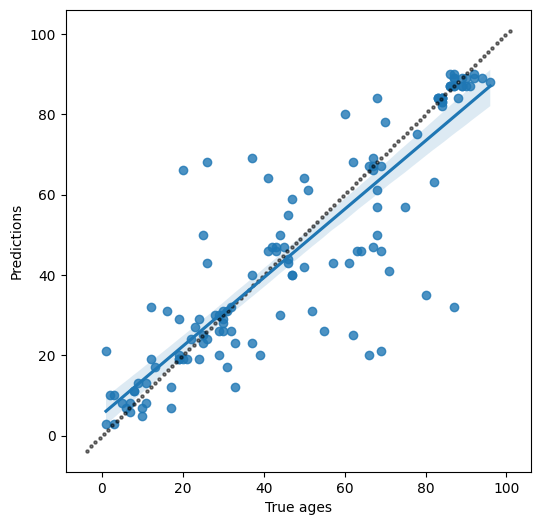

In [5]:
plt.figure(figsize=(6, 6))
regplot(x=true_labels, y=pred_labels)
xlim = plt.xlim()
ylim = plt.ylim()
start = min(xlim[0], ylim[0])
end = max(xlim[1], ylim[1])
correct_line = np.linspace(start, end, 100)
plt.scatter(correct_line, correct_line, c='black', s=5, alpha=0.5)
plt.xlabel('True ages')
plt.ylabel('Predictions')

In [6]:
indices = np.argsort(np.array(true_labels).reshape(-1,), axis=0)

Text(0, 0.5, 'Age')

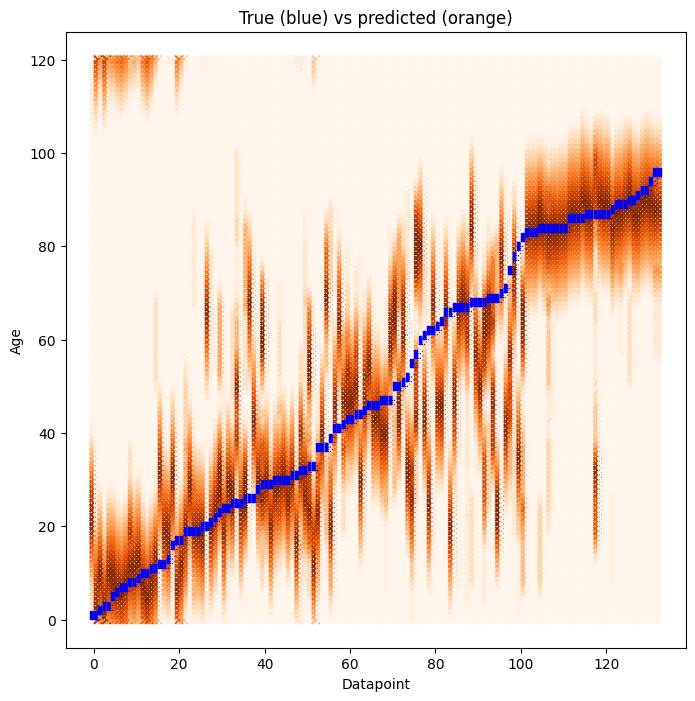

In [7]:
plt.figure(figsize=(8, 8))
for i, index in enumerate(indices):
    line1 = plt.scatter([i]*121, range(121), c=preds[index], marker='x', cmap='Oranges')
    line2 = plt.scatter([i], [true_labels[index]], c='blue', marker='s')
plt.title('True (blue) vs predicted (orange)')
plt.xlabel('Datapoint')
plt.ylabel('Age')

In [9]:
model_folds[4].models[0].coef_.shape
weights = np.zeros(1000)

for model in model_folds:
    for submodel in model.models:
        weights += np.mean(np.abs(submodel.coef_), axis=0)
weights /= (133 * 20)             
weights.shape

(1000,)

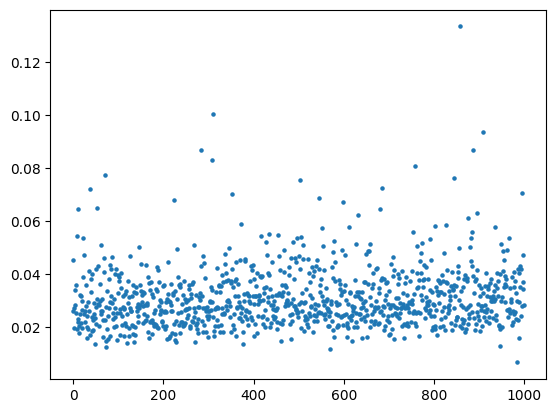

In [10]:
plt.scatter(range(1000), np.abs(weights), s=5)

In [11]:
data.columns[weights.argmax()]

'NM_181643'

In [14]:
sorted_inds = weights.argsort()
sorted_inds[-5:]

array([283, 886, 908, 310, 858])

In [15]:
data.columns[sorted_inds[-5:]]

Index(['NM_001010846', 'NM_014212', 'NR_003716', 'NR_120503', 'NM_181643'], dtype='object')

In [17]:
perturbations = np.zeros(1000)
noises = data.std() * 0.01
for i in range(len(data.columns)):
    splitter = LeaveOneOut()
    pred_labels_perturbed = []

    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        for fold, (train_ind, val_ind) in enumerate(splitter.split(data)):
            model = model_folds[fold]
            pred = model.predict(np.minimum(data.iloc[val_ind] + noises[i], 1.0)).reshape(-1,)
            pred_labels_perturbed.append(pred[0])
            
        perturbations[i] = np.sum(np.array(pred_labels) != np.array(pred_labels_perturbed))
        print(f'[Column {i+1}/1000] ==> {perturbations[i]} changes in predictions')

[Column 1/1000] ==> 2.0 changes in predictions
[Column 2/1000] ==> 2.0 changes in predictions
[Column 3/1000] ==> 2.0 changes in predictions
[Column 4/1000] ==> 2.0 changes in predictions
[Column 5/1000] ==> 2.0 changes in predictions
[Column 6/1000] ==> 2.0 changes in predictions
[Column 7/1000] ==> 2.0 changes in predictions
[Column 8/1000] ==> 2.0 changes in predictions
[Column 9/1000] ==> 2.0 changes in predictions
[Column 10/1000] ==> 2.0 changes in predictions
[Column 11/1000] ==> 2.0 changes in predictions
[Column 12/1000] ==> 2.0 changes in predictions
[Column 13/1000] ==> 0.0 changes in predictions
[Column 14/1000] ==> 2.0 changes in predictions
[Column 15/1000] ==> 2.0 changes in predictions
[Column 16/1000] ==> 2.0 changes in predictions
[Column 17/1000] ==> 0.0 changes in predictions
[Column 18/1000] ==> 2.0 changes in predictions
[Column 19/1000] ==> 2.0 changes in predictions
[Column 20/1000] ==> 2.0 changes in predictions
[Column 21/1000] ==> 2.0 changes in predictions
[

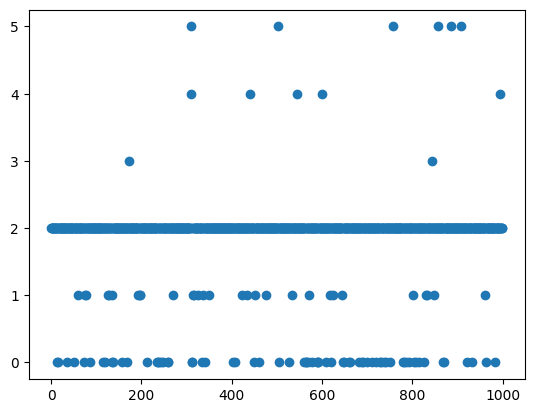

In [18]:
plt.scatter(range(1000), perturbations)

In [20]:
data.columns[perturbations == 5]

Index(['NR_120503', 'NM_001083538', 'NR_073202', 'NM_181643', 'NM_014212',
       'NR_003716'],
      dtype='object')

In [21]:
data.columns[perturbations == 4]

Index(['NM_016593', 'NR_106956', 'NM_002653', 'NM_005069', 'NM_021572'], dtype='object')